In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random

import tensorflow_datasets as tfds

In [8]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteXVTS79/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteXVTS79/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [9]:
ds_train = ds['train']
ds_val = ds['validation']

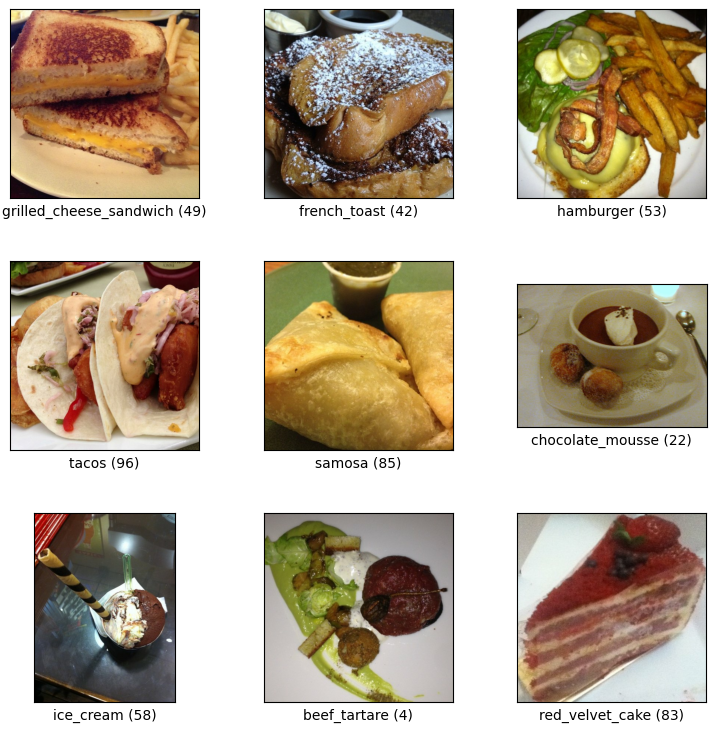

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

In [11]:
# Jesus Christ... Now I don't even need matplotlib while working with tfds

In [12]:
IM_SIZE = 224
HOT_DOG_LABEL = 55
ds_train = ds_train.map(
    lambda img, lbl: (tf.cast(tf.image.resize(img, [IM_SIZE, IM_SIZE]), dtype=tf.int32),
                      tf.cast(lbl == HOT_DOG_LABEL, dtype=tf.int32))
)

ds_val = ds_val.map(
    lambda img, lbl: (tf.cast(tf.image.resize(img, [IM_SIZE, IM_SIZE]), dtype=tf.int32),
                      tf.cast(lbl == HOT_DOG_LABEL, dtype=tf.int32))
)

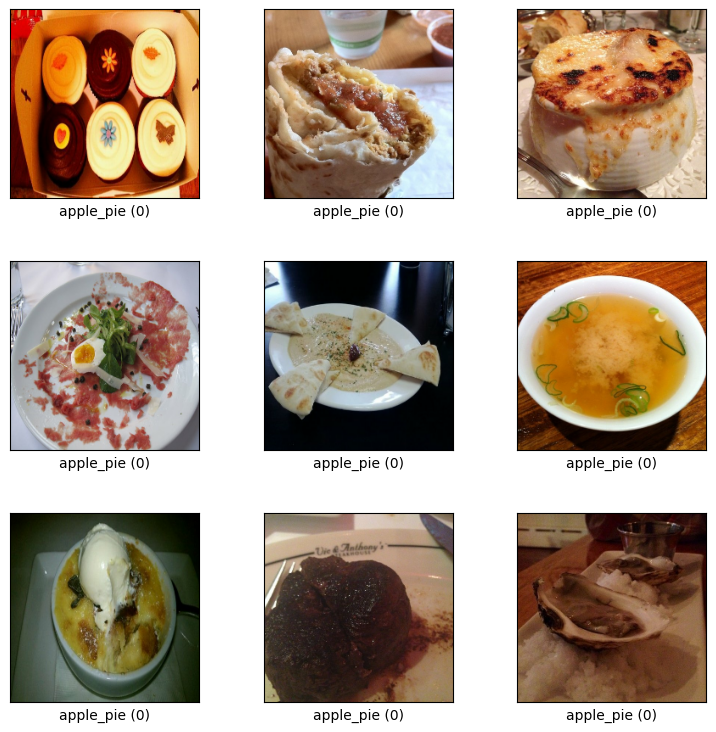

In [13]:
fig = tfds.show_examples(ds_train, ds_info)

In [14]:
# yeah, we f💀cked up with labels, but there's no problem with it

In [15]:
# here apple pie means not hot dog, and baby back ribs means hotdog

In [16]:
train_hd = 750
val_hd = 250

train_hotdogs = ds_train.filter(lambda img, lbl: lbl == 1).repeat(3)
train_not_hotdogs = ds_train.filter(lambda img, lbl: lbl == 0)

val_hotdogs = ds_val.filter(lambda img, lbl: lbl == 1).repeat(3)
val_hotdogs = ds_val.filter(lambda img, lbl: lbl == 0)

In [17]:
batch_size = 16
ds_train = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_not_hotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
ds_train = ds_train.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_val = tf.data.Dataset.sample_from_datasets([val_hotdogs, val_hotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
ds_val = ds_val.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Rescaling

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [20]:
"""model = Sequential([
    Rescaling(1. / 255),
    Conv2D(128, (3, 3), activation='relu', input_shape=(IM_SIZE, IM_SIZE, 3)),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dense(1)
])"""



random.seed(0)
model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(IM_SIZE, IM_SIZE, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))

In [21]:
model.compile(
    optimizer=Adam(0.001),
    loss=BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
  ds_train,
  validation_data=ds_val,
  epochs=10,
  verbose=1
)

Epoch 1/10
    282/Unknown - 389s 1s/step - loss: 1.1559 - accuracy: 0.4977